# Import Libraries

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, classification_report

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [2]:
np.random.seed(21)

# Load Dataset

In [3]:
# Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_df = pd.read_csv("/content/drive/MyDrive/Basic ML/datasets/cleaned-data/data_v2/train.csv", index_col="PassengerId")
val_df = pd.read_csv("/content/drive/MyDrive/Basic ML/datasets/cleaned-data/data_v2/val.csv", index_col="PassengerId")
test_df = pd.read_csv("/content/drive/MyDrive/Basic ML/datasets/cleaned-data/data_v2/test.csv", index_col="PassengerId")

In [5]:
train_df.columns

Index(['Age', 'Fare', 'FamilySize', 'Pclass', 'Sex', 'Embarked', 'Title_Name',
       'Survived'],
      dtype='object')

In [6]:
scale_features = ['Age', 'Fare', 'FamilySize']
encode_features = ['Sex', 'Embarked', 'Title_Name']

features = train_df.columns.to_list()
features.remove('Survived')

# Use GridSearchCV to find suitable Hyperparameters

In [7]:
X_train = train_df[features]
y_train = train_df['Survived']

X_val = val_df[features]
y_val = val_df['Survived']

In [8]:
gs_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), scale_features),
        ('cat', OneHotEncoder(), encode_features)
    ]
)

ada_classifier = AdaBoostClassifier(
    estimator = DecisionTreeClassifier(),
    algorithm='SAMME',
    random_state=42
)

gs_pipline = Pipeline(
    steps=[
        ('preprocessor', gs_preprocessor),
        ('classifier', ada_classifier)
    ]
)

gs_params = {
    'classifier__estimator__criterion': ['gini', 'entropy'],
    'classifier__estimator__class_weight': [None, 'balanced'],
    'classifier__estimator__max_depth': [1, 2, 3, 4, 5],
    'classifier__n_estimators': [50, 100, 150, 200, 300],
    'classifier__learning_rate': [0.001, 0.01, 0.1, 1.0],
}


In [9]:
grid_search = GridSearchCV(estimator=gs_pipline, param_grid=gs_params, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['Age',
                                                                          'Fare',
                                                                          'FamilySize']),
                                                                        ('cat',
                                                                         OneHotEncoder(),
                                                                         ['Sex',
                                                                          'Embarked',
                                                                          'Title_Name'])])),
                                       ('classifier',
                                        AdaBoostClassifier(algorithm='SAMME',
                                                           estimator=DecisionTreeClassifier(),
                                                           random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__estimator__class_weight': [None,
                                                                 'balanced'],
                         'classifier__estimator__criterion': ['gini',
                                                              'entropy'],
                         'classifier__estimator__max_depth': [1, 2, 3, 4, 5],
                         'classifier__learning_rate': [0.001, 0.01, 0.1, 1.0],
                         'classifier__n_estimators': [50, 100, 150, 200, 300]},
             scoring='accuracy')

In [10]:
# Best hyperparameters and corresponding score
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

Best Hyperparameters: {'classifier__estimator__class_weight': None, 'classifier__estimator__criterion': 'gini', 'classifier__estimator__max_depth': 4, 'classifier__learning_rate': 0.1, 'classifier__n_estimators': 50}
Best Cross-Validation Accuracy: 0.834324830099478


In [11]:
best_model = grid_search.best_estimator_
gr_y_pred = best_model.predict(X_val)
print("Accuracy:", accuracy_score(y_val, gr_y_pred))

Accuracy: 0.8044692737430168


# Training a AdaBoosting model

In [12]:
X_train = train_df[features]
y_train = train_df['Survived']

X_val = val_df[features]
y_val = val_df['Survived']

In [13]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), scale_features),
        ('cat', OneHotEncoder(), encode_features)
    ]
)

ada_classifier = AdaBoostClassifier(
    estimator = DecisionTreeClassifier(
        class_weight=None,
        criterion='entropy',
        max_depth=4
    ),
    learning_rate=0.001,
    n_estimators=300,
    algorithm='SAMME',
    random_state=42
)

pipline_model = Pipeline(
    steps=[
        ('preprocessor', gs_preprocessor),
        ('classifier', ada_classifier)
    ]
)

In [14]:
pipline_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Age', 'Fare',
                                                   'FamilySize']),
                                                 ('cat', OneHotEncoder(),
                                                  ['Sex', 'Embarked',
                                                   'Title_Name'])])),
                ('classifier',
                 AdaBoostClassifier(algorithm='SAMME',
                                    estimator=DecisionTreeClassifier(criterion='entropy',
                                                                     max_depth=4),
                                    learning_rate=0.001, n_estimators=300,
                                    random_state=42))])

In [15]:
y_pred = pipline_model.predict(X_val)
print("Accuracy:", accuracy_score(y_val, y_pred))

Accuracy: 0.8156424581005587


# Evaluating Classification Model

## Confusion Matrix

In [16]:
def show_confusion_matrix(y_true: np.ndarray, y_pred: np.ndarray, normalize: bool=False) -> None:
  """

  """
  # Compute the confusion matrix and normalize it
  plt.figure(figsize=(5,5))
  confusion = confusion_matrix(y_true, y_pred)

  axis_labels = range(2)

  if normalize:
    confusion = confusion / confusion.sum(axis=1, keepdims=True)
    ax = sns.heatmap(
        confusion, xticklabels=axis_labels, yticklabels=axis_labels,
        cmap='Blues', annot=True, fmt='.4f', square=True, vmin=0, vmax=1)
  else:
    ax = sns.heatmap(
        confusion, xticklabels=axis_labels, yticklabels=axis_labels,
        cmap='Blues', annot=True, fmt='d', square=True, vmin=0, vmax=len(y_pred))

  plt.title(f"Confusion matrix")
  plt.ylabel("True label")
  plt.xlabel("Predicted label")

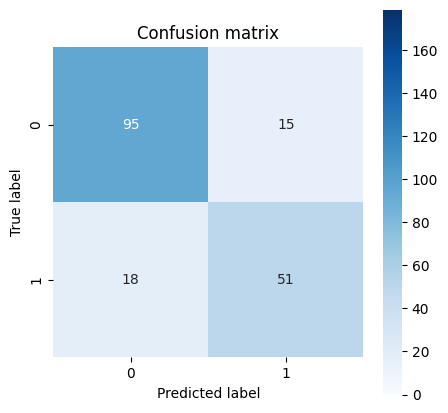

In [17]:
show_confusion_matrix(y_val, y_pred)

## Classification Report

In [18]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.86      0.85       110
           1       0.77      0.74      0.76        69

    accuracy                           0.82       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.81      0.82      0.81       179



**Remarks:**
- Accuracy: 0.82 (82%) — a strong overall performance.
- The model performs well in predicting Class 0, with high precision and recall.
- The model performs slightly worse on Class 1, particularly in recall, which means some positive instances may be misclassified.


## ROC Curve and AUC Scores

AUC: 0.848


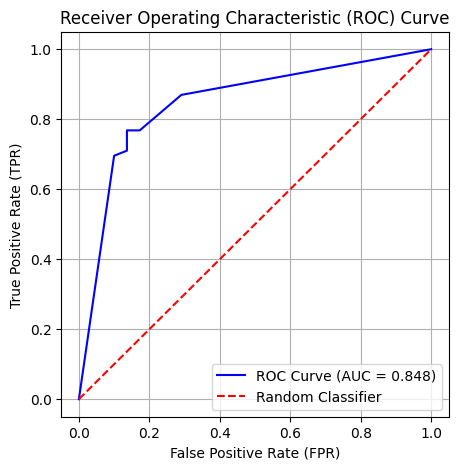

In [19]:
# Predict probabilities for the positive class
y_pred_proba = pipline_model.predict_proba(X_val)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

# Calculate AUC
auc = roc_auc_score(y_val, y_pred_proba)
print(f"AUC: {auc:.3f}")

# Plot ROC Curve
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {auc:.3f})")
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label="Random Classifier")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()

**Remarks:** The AUC (Area Under the Curve) value is 0.848, which indicates that the model has good discriminative ability, as an AUC value above 0.8 is generally considered strong.
- The curve (blue line) lies well above the random classifier (red diagonal line), meaning the model performs significantly better than random guessing.
- The True Positive Rate (TPR) is high for lower False Positive Rates (FPR), showing that the model can effectively distinguish between classes in most scenarios.

In [ ]:
result_metrics_df = pd.read_csv("/content/drive/MyDrive/Basic ML/source codes/result_metrics.csv")

# Save results for comparison between models
from sklearn.metrics import precision_score, recall_score, f1_score

new_row = pd.DataFrame({
    'Model': 'AdaBoost',
    'Accuracy': accuracy_score(y_val, y_pred),
    'Precision': precision_score(y_val, y_pred),
    'Recall': recall_score(y_val, y_pred),
    'F1-Score': f1_score(y_val, y_pred)
}, index=[len(result_metrics_df)])

result_metrics_df = pd.concat([result_metrics_df, new_row], ignore_index=True)

result_metrics_df

,Model,Accuracy,Precision,Recall,F1-Score
0,CART,0.821229,0.862745,0.637681,0.733333
1,Random Forest,0.815642,0.800000,0.695652,0.744186
2,Naive Bayes,0.793296,0.750000,0.695652,0.721805
3,SVM,0.843575,0.825397,0.753623,0.787879
4,SVM,0.815642,0.772727,0.739130,0.755556
5,AdaBoost,0.815642,0.772727,0.739130,0.755556


In [27]:
# result_metrics_df.drop([4], inplace=True)
result_metrics_df.reset_index(inplace=True)

In [29]:
result_metrics_df.drop('index', axis=1, inplace=True)
result_metrics_df

,Model,Accuracy,Precision,Recall,F1-Score
0,CART,0.821229,0.862745,0.637681,0.733333
1,Random Forest,0.815642,0.800000,0.695652,0.744186
2,Naive Bayes,0.793296,0.750000,0.695652,0.721805
3,SVM,0.843575,0.825397,0.753623,0.787879
4,AdaBoost,0.815642,0.772727,0.739130,0.755556


In [ ]:
result_metrics_df.to_csv('/content/drive/MyDrive/Basic ML/source codes/result_metrics.csv', index=False)